In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("/content/combined_data_1.txt",header=None,usecols=[0,1],names=["Cust_Id","Rating"])
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
df.dtypes

,0
Cust_Id,object
Rating,float64


In [5]:
#checking null value
df.isnull().sum()

,0
Cust_Id,0
Rating,192


In [6]:
df.shape

(815366, 2)

In [7]:
movie_count = df.isnull().sum()[1]
# 1 is the index of the count of null values in the ratings column
movie_count


192

In [8]:
# get the customer count with nan values
movie_count = df.isnull().sum()
movie_count = movie_count["Rating"]
movie_count


192

In [9]:
# to calculate how many customers we are having in the dataset
customer_count = df['Cust_Id'].nunique()
customer_count

288418

In [10]:
#without nan values
customer_count = customer_count - movie_count
customer_count

288226

In [11]:
# no. of times a customer has given ratings.
df['Cust_Id'].count()


815366

In [12]:
#get the total no. of ratings given by a customer.
rating_count = df['Cust_Id'].count() - movie_count
rating_count

815174

In [13]:
p = df.groupby('Rating')['Rating'].count()
p

,Rating
Rating,
1.0,36892
2.0,78433
3.0,225722
4.0,289225
5.0,184902


In [14]:
# Rename the series index using 'name' instead of 'columns'
p.rename('Count', inplace=True)
p

,Count
Rating,
1.0,36892
2.0,78433
3.0,225722
4.0,289225
5.0,184902


In [15]:
p.sort_values(ascending = False)

,Count
Rating,
4.0,289225
3.0,225722
5.0,184902
2.0,78433
1.0,36892


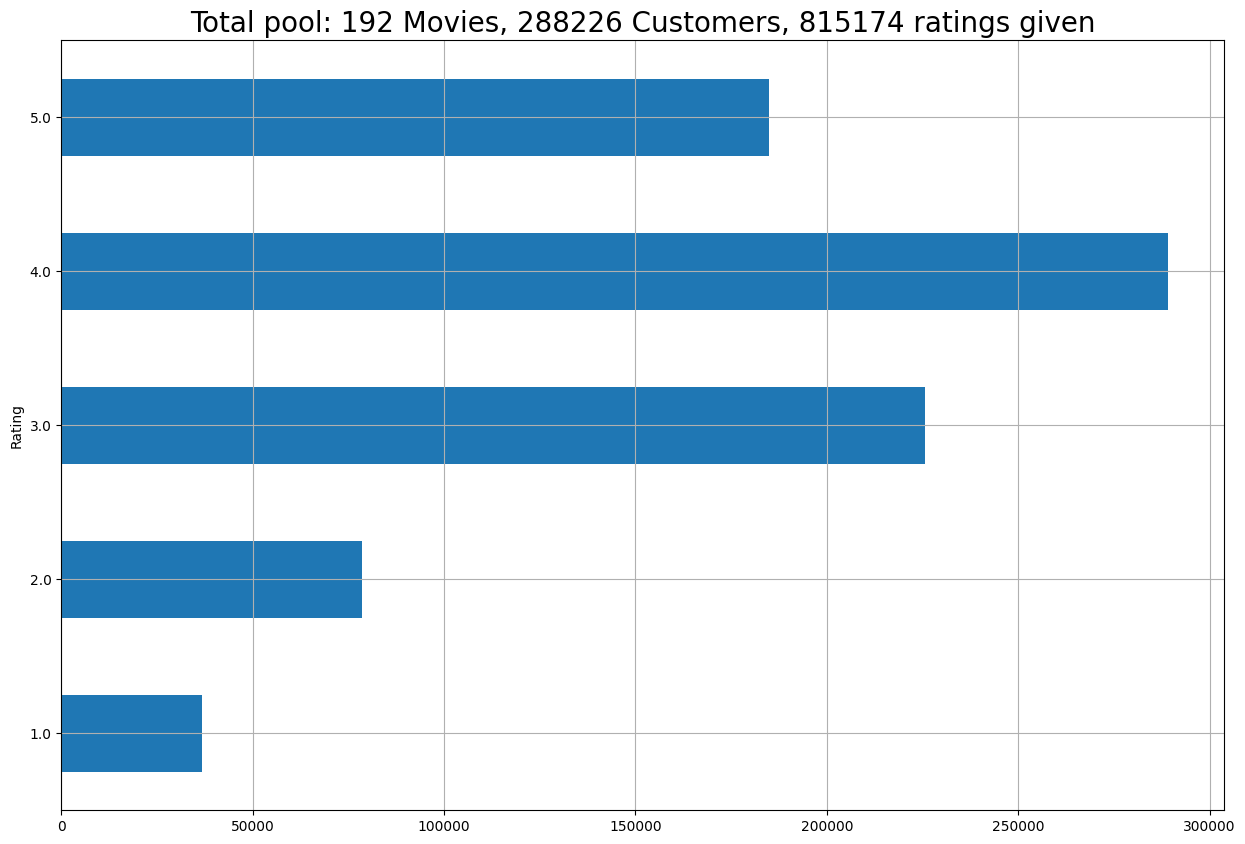

In [16]:
# plotting values
ax = p.plot(kind = 'barh', figsize = (15,10))
plt.title(f'Total pool: {movie_count} Movies, {customer_count} Customers, {rating_count} ratings given', fontsize = 20)
plt.grid(True)

In [18]:
movie_id = None
movie_np = []
for cust_id in df["Cust_Id"]:
  if isinstance(cust_id, str) and ':' in cust_id: # Check if cust_id is a string before checking for ':'
    movie_id = int(cust_id.replace(":", ""))
  movie_np.append(movie_id)

In [19]:
df["Movie_ID"]=movie_np

In [20]:
df

,Cust_Id,Rating,Movie_ID
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
...,...,...,...
815361,165215,5.0,191
815362,1154031,3.0,191
815363,454631,5.0,191
815364,2054365,3.0,191


In [21]:
#Droping null value
df.dropna(inplace=True)

In [ ]:
df

**1. Find out the list of most popular and liked genre**

In [22]:


movies = pd.DataFrame({
    'Movie_ID': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'Genre': ['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Romance', 'Action', 'Comedy', 'Drama', 'Sci-Fi', 'Romance']
})

df_merged = pd.merge(df, movies, on='Movie_ID', how='left')

genre_ratings = df_merged.groupby('Genre')['Rating'].count().reset_index()
most_popular_genre = genre_ratings.loc[genre_ratings['Rating'].idxmax()]


average_genre_ratings = df_merged.groupby('Genre')['Rating'].mean().reset_index()
most_liked_genre = average_genre_ratings.loc[average_genre_ratings['Rating'].idxmax()]

print("Most Popular Genre:")
print(most_popular_genre)

print("\nMost Liked Genre:")
most_liked_genre

Most Popular Genre:
Genre     Drama
Rating     4024
Name: 2, dtype: object

Most Liked Genre:


,3
Genre,Romance
Rating,3.919298


  **2. Create Model that finds the best suited Movie for one
user in every genret**

In [24]:
#To load the movie_titles dataset
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'], on_bad_lines='warn')

df_title.set_index('Movie_Id', inplace = True)

print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


1)To install the scikit-surprise library for implementing SVD

In [26]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357285 sha256=1be90d08bc0d6c054f6c22cc2f8afe629633aa0c298a1dcc3af68cdfd003f123
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [30]:
import math

import matplotlib.pyplot as plt

from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


In [28]:
# Prepare the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_ID', 'Rating']], reader)

In [31]:
# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

In [34]:
# Train the model
algo = SVD()
algo.fit(trainset)

# Predict ratings for the test set
predictions = algo.test(testset)

# Changed 'svd' to 'algo' in the following line:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9909  0.9887  0.9910  0.9902  0.0011  
MAE (testset)     0.7740  0.7725  0.7733  0.7733  0.0006  
Fit time          14.42   14.77   15.29   14.83   0.36    
Test time         2.78    4.39    3.41    3.53    0.66    


{'test_rmse': array([0.99090252, 0.98870468, 0.99099569]),
 'test_mae': array([0.7740069 , 0.772522  , 0.77333557]),
 'fit_time': (14.418895244598389, 14.770315647125244, 15.294771194458008),
 'test_time': (2.7799742221832275, 4.390376091003418, 3.407038688659668)}

In [36]:
df.head()

,Cust_Id,Rating,Movie_ID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [39]:
# Function to Recommend the Best Movie for a User in a Given Genre
def recommend_best_movies(user_id, genre):
    # Merge the 'df' and 'movies' DataFrames to include genre information
    df_merged = pd.merge(df, movies, on='Movie_ID', how='left')

    # Filter movies by genre using the merged DataFrame
    genre_movies = df_merged[df_merged['Genre'] == genre]

    # Exclude movies already rated by the user
    seen_movies = df_merged[df_merged['Cust_Id'] == user_id]['Movie_ID']  # Use 'Cust_Id' from df_merged
    recommendations = genre_movies[~genre_movies['Movie_ID'].isin(seen_movies)]

    # Sort by average predicted rating
    recommendations['Predicted_Rating'] = recommendations['Movie_ID'].apply(
        lambda movie_id: algo.predict(user_id, movie_id).est
    )
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False)

    return recommendations.head(1)  # Return the best-suited movie

 **the best suited Movie for one
user(12345) in every genre(Action)**

In [40]:
best_movie = recommend_best_movies(user_id=12345, genre='Action')
print(best_movie)

   Cust_Id  Rating  Movie_ID   Genre  Predicted_Rating
0  1488844     3.0         1  Action          3.826176


**3. Find what Genre Movies have received the best and
worst ratings based on User Rating**

In [42]:
# Merge the 'df' and 'movies' DataFrames to include genre information
df_merged = pd.merge(df, movies, on='Movie_ID', how='left') # merging the df and movie dataframe on Movie_ID column
genre_stats = df_merged.groupby('Genre').agg( # Using the merged DataFrame 'df_merged' for analysis.
    Average_Rating=('Rating', 'mean'),  # Calculate average rating
    Rating_Count=('Rating', 'count')   # Count total ratings
).reset_index()

# Filter genres with sufficient ratings (e.g., at least 10 ratings)
genre_stats = genre_stats[genre_stats['Rating_Count'] >= 10]

# Sort by average rating to find best and worst rated genres
best_rated_genres = genre_stats.sort_values(by='Average_Rating', ascending=False)
worst_rated_genres = genre_stats.sort_values(by='Average_Rating', ascending=True)

# Display results
print("Best Rated Genres:")
print(best_rated_genres.head())

print("\nWorst Rated Genres:")
print(worst_rated_genres.head())


Best Rated Genres:
     Genre  Average_Rating  Rating_Count
3  Romance        3.919298          2280
0   Action        3.749543          1094
2    Drama        3.641153          4024
1   Comedy        3.558621           290
4   Sci-Fi        2.739437           284

Worst Rated Genres:
     Genre  Average_Rating  Rating_Count
4   Sci-Fi        2.739437           284
1   Comedy        3.558621           290
2    Drama        3.641153          4024
0   Action        3.749543          1094
3  Romance        3.919298          2280
